In [1]:
import matplotlib.pyplot as plt
import os,glob
import numpy as np
import seaborn as sns
from scipy.special import kn,zetac
import pyslha
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))

## Validation of efficiencies for stop pair production for the MS-AGNOSTIC search

### ATLAS Values (from HepDATA)

In [2]:
atlasUL = np.genfromtxt('ATLAS_data/HEPData-ins1718558-v2-Table_11.csv',delimiter=',',
                        names=True,skip_header=18,max_rows=5,usecols=(0,1))
atlasXsecs = np.genfromtxt('ATLAS_data/HEPData-ins1718558-v2-Table_11.csv',delimiter=',',
                        names=True,skip_header=42,max_rows=5,usecols=(0,1))
atlasEffs = np.genfromtxt('ATLAS_data/HEPData-ins1718558-v1-Table_4.csv',delimiter=',',
                        names="SPARTICLE,MASS [GEV],ACC X EFF,error +,error -",
                          skip_header=52,max_rows=5,usecols=(1,2))
atlasSRs = np.genfromtxt('ATLAS_data/HEPData-ins1718558-v1-Table_6.csv',delimiter=',',
                        names=True,skip_header=86,max_rows=4,usecols=(1,2,3))

### Recasting Values

In [3]:
recastXsecs = []
recastEffs = []
for f in glob.glob('sbottom/sbottom_stable_*.slha'):
    slhaData = pyslha.readSLHAFile(f)
    m = slhaData.blocks['MASS'][1000005]
    xsec = slhaData.xsections[2212,2212,-1000005,1000005].get_xsecs(qcd_order=2)
    xsec = xsec[0].value*1000 #xsec in fb
    recastXsecs.append([m,xsec])    
    
    with open(f.replace('.slha','.out'),'r') as effFile:
        effLines = [l for l in effFile.readlines() if "total Efficiency" in l]
        effs = []
        for l in effLines:
            SRlabel,eff = l.split('total Efficiency:')
            SRlabel = SRlabel.strip()
            eff = eval(eff)
            effs.append(eff)
        recastEffs.append([m]+effs)
    
recastXsecs = np.array(sorted(recastXsecs))
recastEffs = np.array(sorted(recastEffs))

### Compare Efficiencies

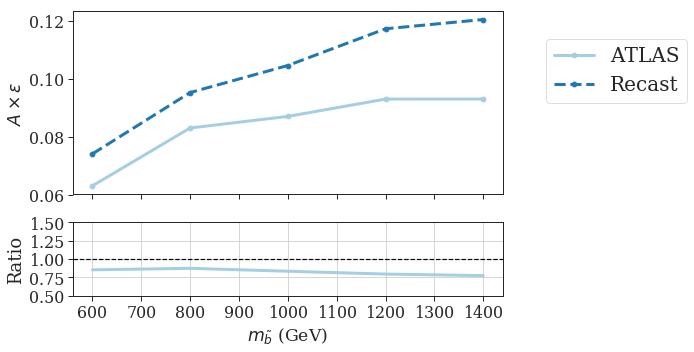

In [4]:
#Get maximum efficiencies
maxEffs = np.array(sorted([[pt[0],pt[1:].max()] for pt in recastEffs]))
atlasEffs.sort()

#Define subplots and their properties:
f, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2.5, 1]},figsize=(10,5))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

#Plot curves
axarr[0].plot(atlasEffs['MASS_GEV'],atlasEffs['ACC_X_EFF'],'o-',label='ATLAS',linewidth=3)
axarr[0].plot(maxEffs[:,0],maxEffs[:,1],'o--',label='Recast',linewidth=3)
axarr[0].set_ylabel(r'$A \times \epsilon$')

#Plot ratio
axarr[1].plot(atlasEffs['MASS_GEV'],atlasEffs['ACC_X_EFF']/maxEffs[:,1],linewidth=3)
axarr[1].axhline(y=1.,c='black',linestyle='--')
axarr[1].set_ylabel('Ratio', fontsize=18) #Y-label
axarr[1].set_xlabel(r'$m_{\tilde{b}}$ (GeV)')
axarr[1].set_ylim(0.5,1.5)
axarr[1].set_yticks([0.5,0.75,1.0,1.25,1.5])
axarr[1].grid(True)
axarr[0].legend(loc=(1.1,0.5),fontsize=20)
f.tight_layout()
f.savefig('sbottom_eff.png')
plt.show()

### Compare Upper Limit

In [5]:
#Get recast upper limits
sigmaUL = []
atlasSRs.sort()
atlasUL.sort()
atlasXsecs.sort()
signalUL = np.array(atlasSRs['XSEC_X_ACC_X_EFF_FB']) #upper limits on the signal xsec*acc*eff (fb) for each SR
for pt in recastEffs:
    sigUL = min([signalUL[i]/eff for i,eff in enumerate(pt[1:]) if eff])
    sigmaUL.append([pt[0],sigUL])
sigmaUL = np.array(sorted(sigmaUL))

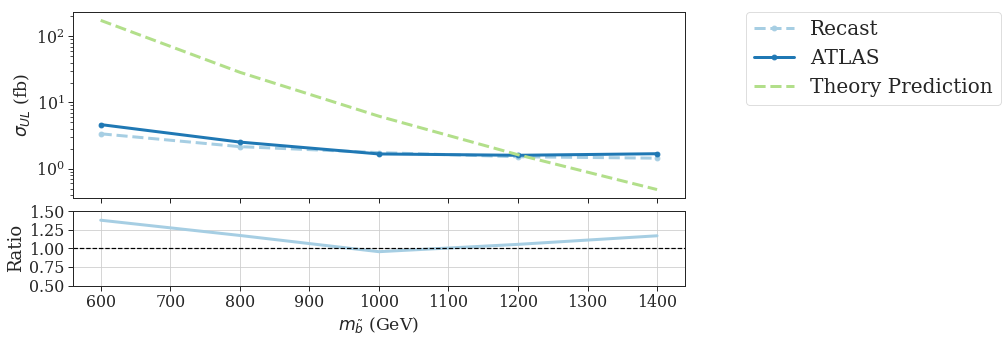

In [7]:
#Define subplots and their properties:
f, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2.5, 1]},figsize=(10,5))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

#Plot curves
axarr[0].plot(sigmaUL[:,0],sigmaUL[:,1],'o--',label='Recast',linewidth=3)
axarr[0].plot(atlasUL['TRUE_MASS_GEV'],atlasUL['OBS_LIMIT_MSAGNOSTIC_FB'],'o-',label='ATLAS',linewidth=3)
axarr[0].plot(recastXsecs[:,0],recastXsecs[:,1],'--',label='Theory Prediction',linewidth=3)
# axarr[0].plot(atlasXsecs['TRUE_MASS_GEV'],atlasXsecs['THEORY_CROSSSECTION_FB'],'--',
#               label='Theory Prediction (ATLAS)',linewidth=3)
axarr[0].set_ylabel(r'$\sigma_{UL}$ (fb)')
axarr[0].set_yscale('log')

#Plot ratio
axarr[1].plot(atlasUL['TRUE_MASS_GEV'],atlasUL['OBS_LIMIT_MSAGNOSTIC_FB']/sigmaUL[:,1],linewidth=3)
axarr[1].axhline(y=1.,c='black',linestyle='--')
axarr[1].set_ylabel('Ratio', fontsize=18) #Y-label
axarr[1].set_xlabel(r'$m_{\tilde{b}}$ (GeV)')
axarr[1].set_ylim(0.5,1.5)
axarr[1].set_yticks([0.5,0.75,1.0,1.25,1.5])
axarr[1].grid(True)
axarr[0].legend(loc=(1.1,0.5),fontsize=20)
f.savefig('sbottom_UL.png')
plt.show()